In [7]:
import numpy as np
import matplotlib.pyplot as plt
import visualization
import os
from gta_math import points_to_homo, ndc_to_view, construct_proj_matrix, view_to_world, construct_view_matrix, ndcs_to_pixels
from visualization import load_depth, save_pointcloud_csv
import progressbar
from pointcloud_to_voxelmap import pointclouds_to_voxelmap
from joblib import Parallel, delayed
from configparser import ConfigParser
from PIL import Image
import pickle
import json
from voxelmaps import camera_to_pointcloud, load_scene_db_data, get_main_image_name, scene_to_voxelmap, get_main_image, scene_to_voxelmap_with_map, convert_ndc_pointcloud_to_bool_grid
import voxelmaps

In [16]:
ini_file = "gta-postprocessing.ini"
visualization.multi_page = False
visualization.ini_file = ini_file

conn = visualization.get_connection_pooled()
cur = conn.cursor()

CONFIG = ConfigParser()
CONFIG.read(ini_file)
in_directory = CONFIG["Images"]["Tiff"]
out_directory = CONFIG["Images"]["MlDatasetVoxel"]
out_inspect_directory = r'D:\showing-pointclouds'

voxelmaps.MAX_DISTANCE = 25

In [25]:
#scene_id = '623b6ace-2a9c-4067-8c5f-42cb46d56f53' # from 4cameras on car run, I think
scene_id = '386b407b-586c-4d88-9d41-8dc2a0b70e70' # from voxelmap run

cameras = load_scene_db_data(scene_id)

base_name = get_main_image_name(cameras)
voxels, values, map_voxel_size, map_obj = scene_to_voxelmap_with_map(cameras)
occupied_voxels = voxels[:, values >= 0]
pointcloud = camera_to_pointcloud(get_main_image(cameras))

In [26]:
cam = get_main_image(cameras)
proj_matrix = cam['proj_matrix']
view_matrix = cam['view_matrix']
width = cam['width']
height = cam['height']

In [27]:
x_min = -1
x_max = 1
y_min = -1
y_max = 1
x_range = 240
y_range = 160
z_meters_min = 1.5
z_meters_max = voxelmaps.MAX_DISTANCE
# z min calc
z_min = proj_matrix @ [1, 1, -z_meters_max, 1]
z_min = z_min[2] / z_min[3]
# z max calc
z_max = proj_matrix @ [1, 1, -z_meters_min, 1]
z_max = z_max[2] / z_max[3]
z_range = 100
x_bin = (x_max - x_min) / x_range
y_bin = (y_max - y_min) / y_range
z_bin = (z_max - z_min) / z_range


In [28]:
# now I need to calculate correct Z points, deformed in NDC, linear in view frustum
z_view_bin = (z_meters_max - z_meters_min) / z_range
#X_view, Y_view, Z_view, W_view = np.mgrid[1:2:1, 1:2:1, -z_meters_max:-z_meters_min+1e-7:z_view_bin, 1:2:1]  # W is here as homo coordinate
X_view, Y_view, Z_view, W_view = np.meshgrid(np.linspace(1,2,1), np.linspace(1,2,1), np.linspace(-z_meters_max,-z_meters_min,z_range), np.linspace(1,2,1))
view_positions = np.vstack([X_view.ravel(), Y_view.ravel(), Z_view.ravel(), W_view.ravel()])
ndc_positions = proj_matrix @ view_positions
ndc_positions /= ndc_positions[3, :]
ndc_z = ndc_positions[2, :]
ndc_z_tiled = np.tile(ndc_z,(x_range, y_range, 1))[:, :, :, np.newaxis]

In [29]:
#X, Y, Z, W = np.mgrid[x_min:x_max:x_bin, y_min:y_max:y_bin, z_min:z_max:z_bin, 1:2:1]  # W is here as homo coordinate
X, Y, Z, W = np.meshgrid(np.linspace(x_min,x_max,x_range), np.linspace(y_min,y_max,y_range), np.linspace(z_min,z_max,z_range), np.linspace(1,2,1))
positions = np.vstack([X.ravel(), Y.ravel(), Z.ravel(), W.ravel()])
positions_fixed = np.vstack([X.ravel(), Y.ravel(), ndc_z_tiled.ravel(), W.ravel()])

In [30]:
params = {
    'width': width,
    'height': height,
    'proj_matrix': proj_matrix,
}

points_view = ndc_to_view(positions, proj_matrix)
points_world = view_to_world(points_view, view_matrix)
# here I find corresponding voxels for generated points, by obtaining voxelmap reference
voxel_values = map_obj.get_voxels(points_world[0:3, :], np.zeros((points_world.shape[1], 1)))
occupied_selected_voxels_view = points_view[:, voxel_values > 0]
occupied_ndc_positions = positions[:, voxel_values > 0]

w = np.ones((1,occupied_voxels.shape[1]))
voxels_homo = np.vstack([occupied_voxels, w])
voxels_view = view_matrix @ voxels_homo
w = np.ones((1,pointcloud.shape[1]))
pointcloud_homo = np.vstack([pointcloud, w])
pointcloud_view = view_matrix @ pointcloud_homo

points_view_fixed = ndc_to_view(positions_fixed, proj_matrix)
points_world_fixed = view_to_world(points_view_fixed, view_matrix)
voxel_values_fixed = map_obj.get_voxels(points_world_fixed[0:3, :], np.zeros((points_world_fixed.shape[1], 1)))
occupied_selected_voxels_view_fixed = points_view_fixed[:, voxel_values_fixed > 0]
occupied_ndc_positions_fixed = positions_fixed[:, voxel_values_fixed > 0]



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


In [31]:
save_pointcloud_csv(points_view.T[:, 0:3], '{}/{}.csv'.format(out_inspect_directory, base_name))
save_pointcloud_csv(points_view_fixed.T[:, 0:3], '{}/fixed-{}.csv'.format(out_inspect_directory, base_name))
save_pointcloud_csv(positions.T[:, 0:3], '{}/ndc-{}.csv'.format(out_inspect_directory, base_name))
save_pointcloud_csv(occupied_selected_voxels_view.T[:, 0:3], '{}/voxels-{}.csv'.format(out_inspect_directory, base_name))
save_pointcloud_csv(voxels_view.T[:, 0:3], '{}/orig-voxels-{}.csv'.format(out_inspect_directory, base_name))
save_pointcloud_csv(occupied_ndc_positions.T[:, 0:3], '{}/ndc-occupied-{}.csv'.format(out_inspect_directory, base_name))
save_pointcloud_csv(pointcloud_view.T[:, 0:3], '{}/orig-pointcloud-{}.csv'.format(out_inspect_directory, base_name))
save_pointcloud_csv(occupied_selected_voxels_view_fixed.T[:, 0:3], '{}/voxels-fixed-{}.csv'.format(out_inspect_directory, base_name))
save_pointcloud_csv(occupied_voxels.T[:, 0:3], '{}/all-voxels-{}.csv'.format(out_inspect_directory, base_name))


In [32]:
# now I create x X y X z grid with 0s and 1s as grid
# so now I have data in pointcloud. And I need to convert these NDC values
# into indices, so x:[-1, 1] into [0, 239], y:[-1, 1] to [0, 159], 
# and z:[z_min, z_max] into [0, 99]
voxelmap_ndc_grid = np.zeros((x_range, y_range, z_range), dtype=np.bool)
vecs = ndcs_to_pixels(occupied_ndc_positions[0:2, :], (y_range, x_range))
vec_y = vecs[0, :]
vec_x = vecs[1, :]
vec_z = ((occupied_ndc_positions[2, :] - z_min) / z_bin).astype(np.int32)
voxelmap_ndc_grid[vec_x, vec_y, vec_z] = 1


In [33]:
voxels.shape

(3, 84653)

In [34]:
w = np.ones((1,voxels.shape[1]))

In [35]:
voxels_homo.shape

(4, 22430)

In [36]:
points_world[0:3, :].shape

(3, 3840000)

In [37]:
positions.T[:, 0:3].shape

(3840000, 3)

In [38]:
occupied_voxels.T[:, 0:3].shape

(22430, 3)

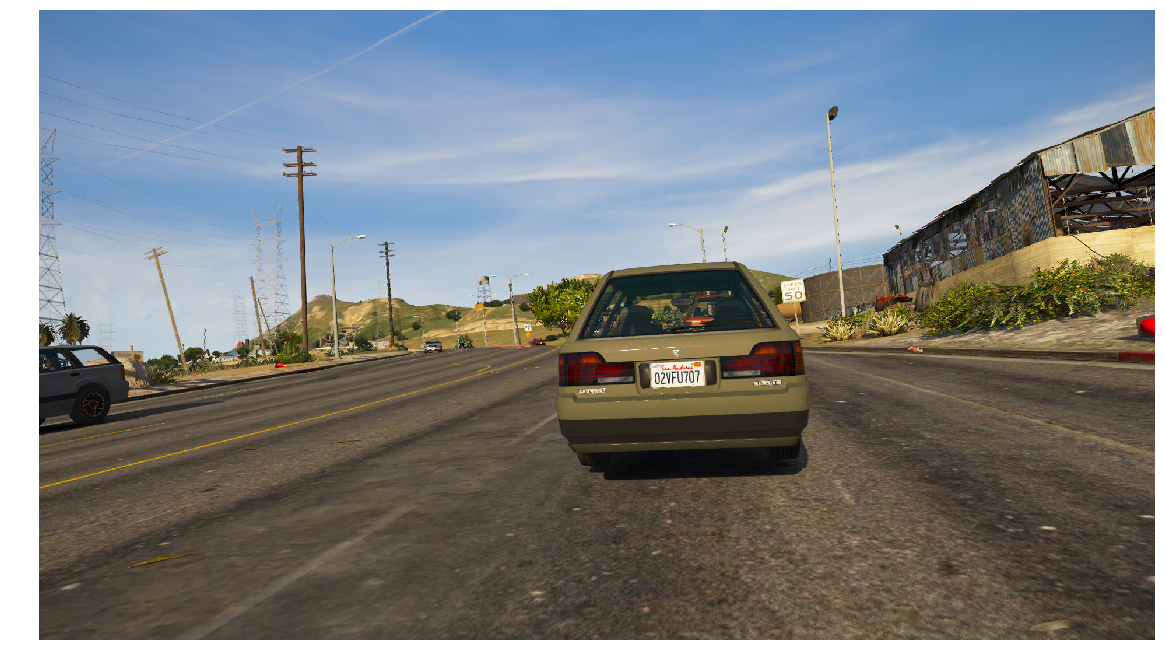

In [44]:
#rgb_img_name = os.path.join(r'D:\generic-dataset', '{}.jpg'.format('2018-03-30--06-00-56--114'))
rgb_img_name = os.path.join(in_directory, '{}.tiff'.format(base_name))
im = Image.open(rgb_img_name)
im = im.convert(mode="RGB")
arr = np.array(im)

plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(arr)
plt.show()

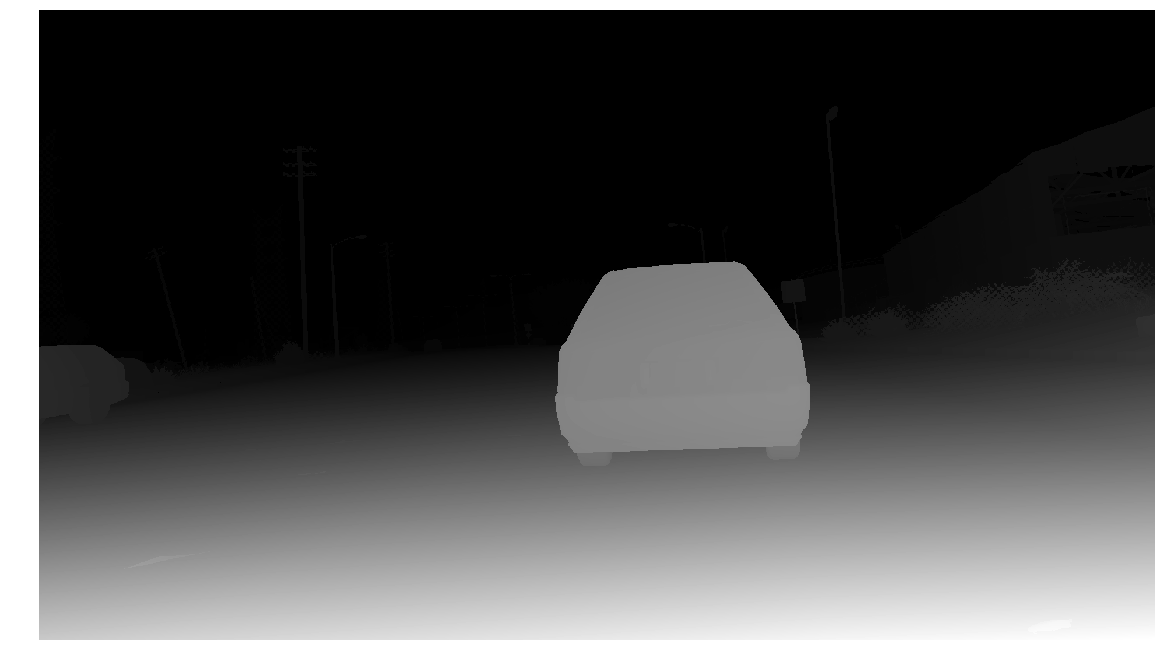

In [46]:
depth = load_depth(base_name)

plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(depth, cmap='gray')
plt.show()

In [47]:
base_name

'2018-03-07--17-57-32--527'

In [48]:
display(occupied_ndc_positions.min(axis=1))
display(occupied_ndc_positions.max(axis=1))
occupied_ndc_positions.shape


array([-1.        , -1.        ,  0.05985903,  1.        ])

array([ 1.        ,  0.29559748,  0.78158341,  1.        ])

(4, 181081)

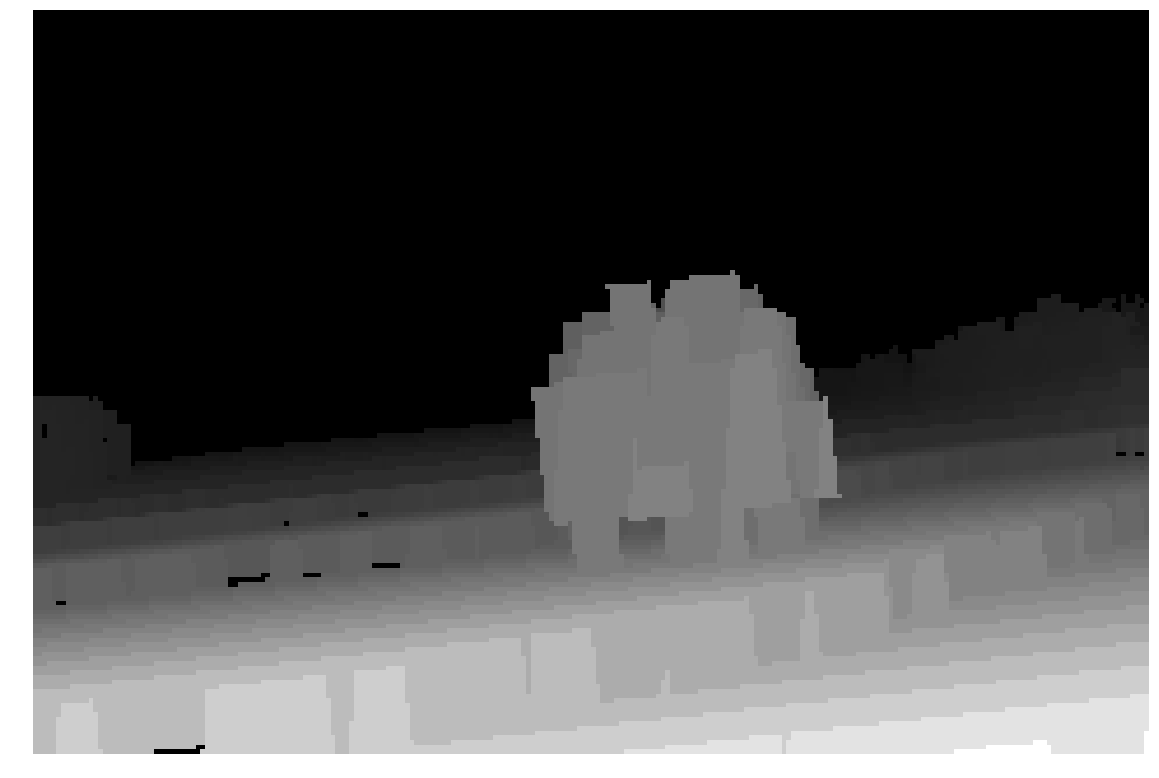

In [51]:
# for debug purposes, now I visualize the voxelmap in NDC as image
new_depth = np.zeros((y_range, x_range))
vecs = ndcs_to_pixels(occupied_ndc_positions_fixed[0:2, :], (y_range, x_range))
vec_y = vecs[0, :]
vec_x = vecs[1, :]
vec_z = occupied_ndc_positions_fixed[2, :]
new_depth[vec_y, vec_x] = vec_z

plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(new_depth, cmap='gray')
plt.show()

In [258]:
display(vecs.min(axis=1))
display(vecs.max(axis=1))
vecs.shape


array([0, 0])

array([159, 239])

(2, 192175)

In [259]:
vec_x.max()

239

In [260]:
occupied_ndc_positions.max(axis=1)
np.unique(occupied_ndc_positions[2, :]).shape

(92,)

In [285]:
np.unique(occupied_ndc_positions[2, :])

array([ 0.02985453,  0.03965398,  0.04945343,  0.05925288,  0.06905233,
        0.07885178,  0.08865123,  0.09845068,  0.10825013,  0.11804958,
        0.12784903,  0.13764847,  0.14744792,  0.15724737,  0.16704682,
        0.17684627,  0.18664572,  0.19644517,  0.20624462,  0.21604407,
        0.22584352,  0.23564297,  0.24544242,  0.25524186,  0.26504131,
        0.27484076,  0.28464021,  0.29443966,  0.30423911,  0.31403856,
        0.32383801,  0.33363746,  0.34343691,  0.35323636,  0.3630358 ,
        0.37283525,  0.3826347 ,  0.39243415,  0.4022336 ,  0.41203305,
        0.4218325 ,  0.43163195,  0.4414314 ,  0.45123085,  0.4610303 ,
        0.47082975,  0.48062919,  0.49042864,  0.50022809,  0.51002754,
        0.51982699,  0.52962644,  0.53942589,  0.54922534,  0.55902479,
        0.56882424,  0.57862369,  0.58842314,  0.59822258,  0.60802203,
        0.61782148,  0.62762093,  0.63742038,  0.64721983,  0.65701928,
        0.66681873,  0.67661818,  0.68641763,  0.69621708,  0.70

In [268]:
np.unique(occupied_ndc_positions[2, :]) * z_range

array([  2.98545337,   3.96539828,   4.9453432 ,   5.92528811,
         6.90523303,   7.88517794,   8.86512286,   9.84506778,
        10.82501269,  11.80495761,  12.78490252,  13.76484744,
        14.74479235,  15.72473727,  16.70468218,  17.6846271 ,
        18.66457202,  19.64451693,  20.62446185,  21.60440676,
        22.58435168,  23.56429659,  24.54424151,  25.52418642,
        26.50413134,  27.48407625,  28.46402117,  29.44396609,
        30.423911  ,  31.40385592,  32.38380083,  33.36374575,
        34.34369066,  35.32363558,  36.30358049,  37.28352541,
        38.26347032,  39.24341524,  40.22336016,  41.20330507,
        42.18324999,  43.1631949 ,  44.14313982,  45.12308473,
        46.10302965,  47.08297456,  48.06291948,  49.0428644 ,
        50.02280931,  51.00275423,  51.98269914,  52.96264406,
        53.94258897,  54.92253389,  55.9024788 ,  56.88242372,
        57.86236863,  58.84231355,  59.82225847,  60.80220338,
        61.7821483 ,  62.76209321,  63.74203813,  64.72

In [295]:
(np.unique(occupied_ndc_positions[2, :]) - z_min) * ((z_range-1) / (z_max - z_min))

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,
        94.,  95.,  96.,  97.])

In [292]:
print(z_bin)
print(z_min)
print(z_max)
print(z_min / z_bin)
print(z_max / z_bin)
print(z_max - z_min)

0.00970145466325
0.0298545336755
1.0
3.07732548486
103.077325485
0.970145466325


In [288]:
(np.unique(occupied_ndc_positions[2, :]) - z_min) / z_bin

array([  0.        ,   1.01010101,   2.02020202,   3.03030303,
         4.04040404,   5.05050505,   6.06060606,   7.07070707,
         8.08080808,   9.09090909,  10.1010101 ,  11.11111111,
        12.12121212,  13.13131313,  14.14141414,  15.15151515,
        16.16161616,  17.17171717,  18.18181818,  19.19191919,
        20.2020202 ,  21.21212121,  22.22222222,  23.23232323,
        24.24242424,  25.25252525,  26.26262626,  27.27272727,
        28.28282828,  29.29292929,  30.3030303 ,  31.31313131,
        32.32323232,  33.33333333,  34.34343434,  35.35353535,
        36.36363636,  37.37373737,  38.38383838,  39.39393939,
        40.4040404 ,  41.41414141,  42.42424242,  43.43434343,
        44.44444444,  45.45454545,  46.46464646,  47.47474747,
        48.48484848,  49.49494949,  50.50505051,  51.51515152,
        52.52525253,  53.53535354,  54.54545455,  55.55555556,
        56.56565657,  57.57575758,  58.58585859,  59.5959596 ,
        60.60606061,  61.61616162,  62.62626263,  63.63

In [273]:
np.size(voxelmap_ndc_grid) #181289, 3840000

3840000

In [274]:
x_range * y_range * z_range

3840000

In [275]:
voxelmap_ndc_grid.shape

(240, 160, 100)

### playing with depths projections

In [227]:
z_meters_min = 1.5
z_meters_max = voxelmaps.MAX_DISTANCE
# z min calc
z_min = proj_matrix @ [1, 1, -z_meters_max, 1]
z_min = z_min[2] / z_min[3]
# z max calc
z_max = proj_matrix @ [1, 1, -z_meters_min, 1]
z_max = z_max[2] / z_max[3]
z_range = 100
z_bin = (z_max - z_min) / (z_range)
#X, Y, Z, W = np.mgrid[1:2:1, 1:2:1, z_min:z_max:z_bin, 1:2:1]  # W is here as homo coordinate
X, Y, Z, W = np.meshgrid(np.linspace(1,2,1), np.linspace(1,2,1), np.linspace(z_min,z_max,z_range), np.linspace(1,2,1))
positions = np.vstack([X.ravel(), Y.ravel(), Z.ravel(), W.ravel()])
points_view = ndc_to_view(positions, proj_matrix)

In [228]:
positions[2, :].shape

(100,)

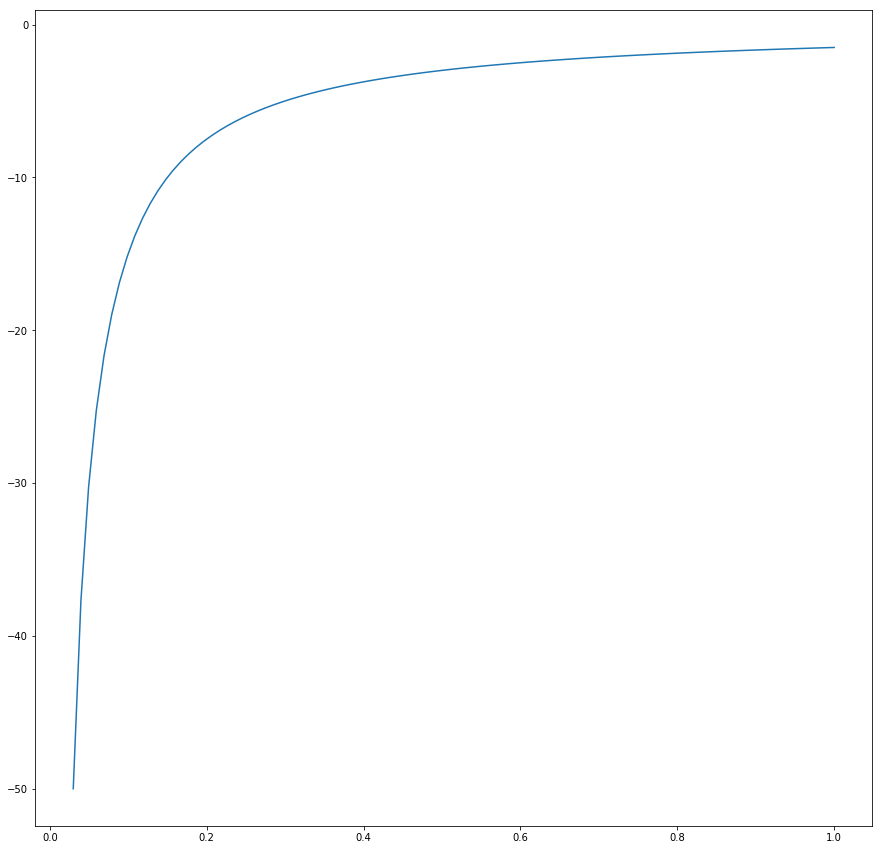

In [229]:
plt.figure(figsize=(15,15))
plt.plot(positions[2, :], points_view[2, :])
plt.show()

In [230]:
print(positions[2, :].max())
print(positions[2, :].min())
print(points_view[2, :].max())
print(points_view[2, :].min())


1.0
0.0298545336755
-1.5
-50.0


In [234]:
z_bin = (z_meters_max - z_meters_min) / (z_range)
#X, Y, Z, W = np.mgrid[1:2:1, 1:2:1, -z_meters_max:-z_meters_min:z_bin, 1:2:1]  # W is here as homo coordinate
X, Y, Z, W = np.meshgrid(np.linspace(1,2,1), np.linspace(1,2,1), np.linspace(-z_meters_max,-z_meters_min,z_range), np.linspace(1,2,1))
view_positions = np.vstack([X.ravel(), Y.ravel(), Z.ravel(), W.ravel()])
ndc_positions = proj_matrix @ view_positions
ndc_positions /= ndc_positions[3, :]


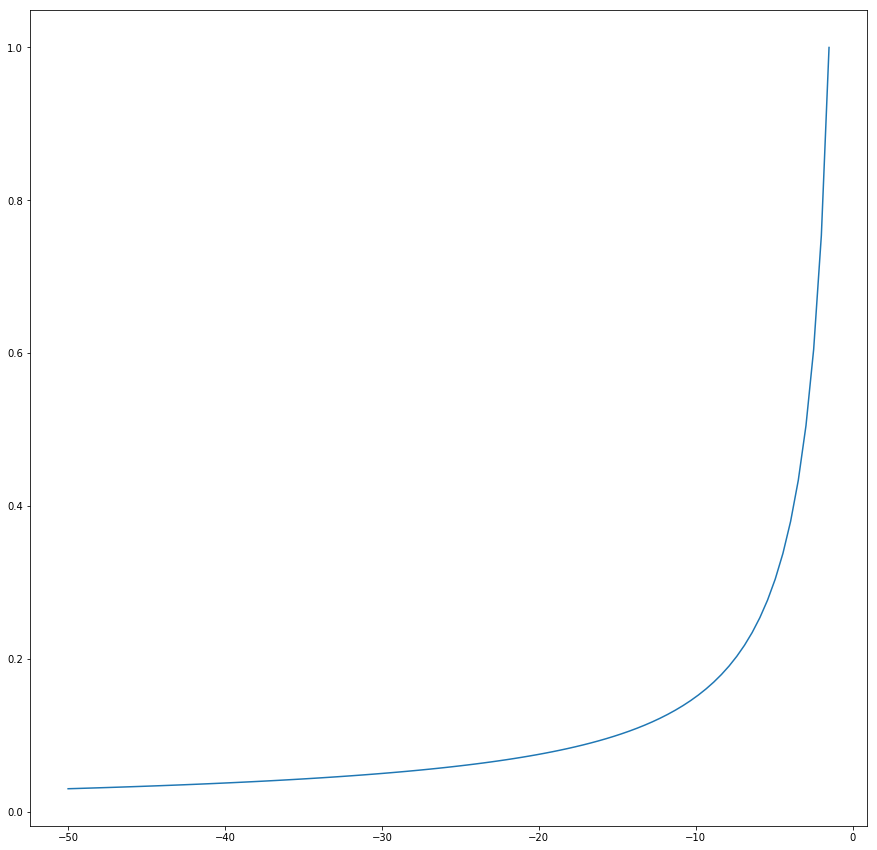

In [235]:
plt.figure(figsize=(15,15))
plt.plot(view_positions[2, :], ndc_positions[2, :])
plt.show()

In [236]:
print(ndc_positions[2, :].max())
print(ndc_positions[2, :].min())
print(view_positions[2, :].max())
print(view_positions[2, :].min())


1.0
0.0298545336755
-1.5
-50.0


In [211]:
view_positions[2, :].shape

(100,)

In [184]:
list(np.mgrid[-z_meters_max:-z_meters_min+1e-7:z_bin])

[-30.0,
 -29.715,
 -29.43,
 -29.145,
 -28.859999999999999,
 -28.574999999999999,
 -28.289999999999999,
 -28.004999999999999,
 -27.719999999999999,
 -27.434999999999999,
 -27.149999999999999,
 -26.864999999999998,
 -26.579999999999998,
 -26.294999999999998,
 -26.009999999999998,
 -25.724999999999998,
 -25.439999999999998,
 -25.154999999999998,
 -24.869999999999997,
 -24.584999999999997,
 -24.299999999999997,
 -24.014999999999997,
 -23.729999999999997,
 -23.444999999999997,
 -23.159999999999997,
 -22.874999999999996,
 -22.589999999999996,
 -22.304999999999996,
 -22.019999999999996,
 -21.734999999999996,
 -21.449999999999996,
 -21.164999999999996,
 -20.879999999999995,
 -20.594999999999995,
 -20.309999999999995,
 -20.024999999999995,
 -19.739999999999995,
 -19.454999999999995,
 -19.169999999999995,
 -18.884999999999994,
 -18.599999999999994,
 -18.314999999999994,
 -18.029999999999994,
 -17.744999999999994,
 -17.459999999999994,
 -17.174999999999994,
 -16.889999999999993,
 -16.604999999999

In [212]:
view_positions[2, :]

array([-50.   , -49.515, -49.03 , -48.545, -48.06 , -47.575, -47.09 ,
       -46.605, -46.12 , -45.635, -45.15 , -44.665, -44.18 , -43.695,
       -43.21 , -42.725, -42.24 , -41.755, -41.27 , -40.785, -40.3  ,
       -39.815, -39.33 , -38.845, -38.36 , -37.875, -37.39 , -36.905,
       -36.42 , -35.935, -35.45 , -34.965, -34.48 , -33.995, -33.51 ,
       -33.025, -32.54 , -32.055, -31.57 , -31.085, -30.6  , -30.115,
       -29.63 , -29.145, -28.66 , -28.175, -27.69 , -27.205, -26.72 ,
       -26.235, -25.75 , -25.265, -24.78 , -24.295, -23.81 , -23.325,
       -22.84 , -22.355, -21.87 , -21.385, -20.9  , -20.415, -19.93 ,
       -19.445, -18.96 , -18.475, -17.99 , -17.505, -17.02 , -16.535,
       -16.05 , -15.565, -15.08 , -14.595, -14.11 , -13.625, -13.14 ,
       -12.655, -12.17 , -11.685, -11.2  , -10.715, -10.23 ,  -9.745,
        -9.26 ,  -8.775,  -8.29 ,  -7.805,  -7.32 ,  -6.835,  -6.35 ,
        -5.865,  -5.38 ,  -4.895,  -4.41 ,  -3.925,  -3.44 ,  -2.955,
        -2.47 ,  -1.

In [93]:
z_bin

0.485

In [70]:
-1.9850000000000563 + z_bin

-1.5000000000000564

In [95]:
-z_meters_max + (z_bin * 99)

-1.9849999999999994

In [115]:
ndc_positions[2, :]

array([ 0.02985453,  0.03015143,  0.03045425,  0.03076319,  0.03107843,
        0.03140017,  0.03172861,  0.03206395,  0.03240643,  0.03275626,
        0.0331137 ,  0.03347899,  0.03385239,  0.03423417,  0.03462462,
        0.03502405,  0.03543275,  0.03585107,  0.03627934,  0.03671792,
        0.03716719,  0.03762754,  0.0380994 ,  0.03858319,  0.03907937,
        0.03958843,  0.04011088,  0.04064725,  0.04119811,  0.04176404,
        0.04234568,  0.04294369,  0.04355877,  0.04419166,  0.04484315,
        0.04551407,  0.0462053 ,  0.04691778,  0.0476525 ,  0.04841053,
        0.04919298,  0.05000106,  0.05083605,  0.05169932,  0.05259232,
        0.05351662,  0.05447389,  0.05546594,  0.05649468,  0.0575622 ,
        0.05867074,  0.05982269,  0.06102066,  0.06226746,  0.06356615,
        0.06492003,  0.0663327 ,  0.06780806,  0.06935039,  0.07096436,
        0.07265507,  0.07442813,  0.0762897 ,  0.07824659,  0.0803063 ,
        0.08247717,  0.08476843,  0.08719039,  0.08975456,  0.09

# new NDC sampling, with nonlinear Z axis which will be mapped to linear distances in view frustum

In [237]:
z_meters_min = 1.5
z_meters_max = voxelmaps.MAX_DISTANCE
# z min calc
z_min = proj_matrix @ [1, 1, -z_meters_max, 1]
z_min = z_min[2] / z_min[3]
# z max calc
z_max = proj_matrix @ [1, 1, -z_meters_min, 1]
z_max = z_max[2] / z_max[3]
z_range = 100
z_bin = (z_max - z_min) / z_range
#X, Y, Z, W = np.mgrid[1:2:1, 1:2:1, z_min:z_max+1e-7:z_bin, 1:2:1]  # W is here as homo coordinate
X, Y, Z, W = np.meshgrid(np.linspace(1,2,1), np.linspace(1,2,1), np.linspace(z_min,z_max,z_range), np.linspace(1,2,1))
positions = np.vstack([X.ravel(), Y.ravel(), ndc_positions[2, :], W.ravel()])
points_view = ndc_to_view(positions, proj_matrix)

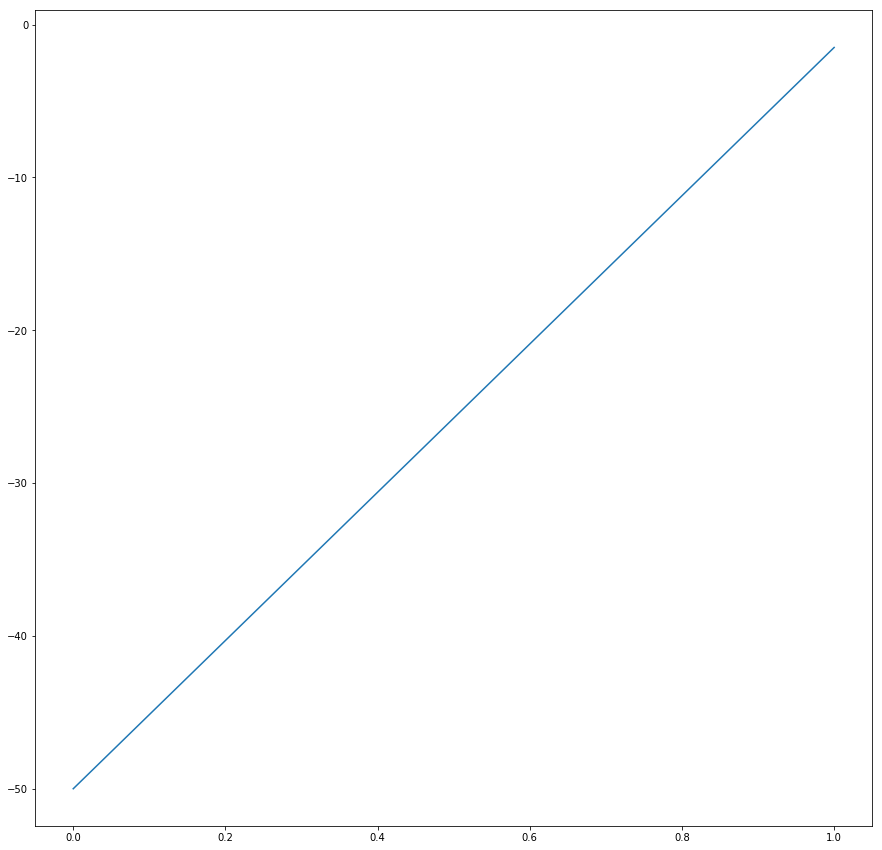

In [238]:
plt.figure(figsize=(15,15))
plt.plot(np.linspace(0, 1, len(points_view[2, :])), points_view[2, :])
plt.show()

In [239]:
ndc_z_tiled = np.tile(ndc_z,(240, 160, 1))[:, :, :, np.newaxis]

In [240]:
Z.shape

(1, 1, 100, 1)

In [143]:
Z[:].shape

(240, 160, 100, 1)

In [149]:
Z[0, :, 0, 0]

array([ 0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02985453,
        0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02985453,
        0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02985453,
        0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02985453,
        0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02985453,
        0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02985453,
        0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02985453,
        0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02985453,
        0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02985453,
        0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02985453,
        0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02985453,
        0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02985453,
        0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02985453,
        0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02

In [146]:
ndc_z_tiled[0, :, 0, 0]

array([ 0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02985453,
        0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02985453,
        0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02985453,
        0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02985453,
        0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02985453,
        0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02985453,
        0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02985453,
        0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02985453,
        0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02985453,
        0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02985453,
        0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02985453,
        0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02985453,
        0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02985453,
        0.02985453,  0.02985453,  0.02985453,  0.02985453,  0.02

In [150]:
Z - ndc_z_tiled

array([[[[ 0.        ],
         [ 0.00940456],
         [ 0.01880319],
         ..., 
         [ 0.36606691],
         [ 0.2268269 ],
         [-0.00970145]],

        [[ 0.        ],
         [ 0.00940456],
         [ 0.01880319],
         ..., 
         [ 0.36606691],
         [ 0.2268269 ],
         [-0.00970145]],

        [[ 0.        ],
         [ 0.00940456],
         [ 0.01880319],
         ..., 
         [ 0.36606691],
         [ 0.2268269 ],
         [-0.00970145]],

        ..., 
        [[ 0.        ],
         [ 0.00940456],
         [ 0.01880319],
         ..., 
         [ 0.36606691],
         [ 0.2268269 ],
         [-0.00970145]],

        [[ 0.        ],
         [ 0.00940456],
         [ 0.01880319],
         ..., 
         [ 0.36606691],
         [ 0.2268269 ],
         [-0.00970145]],

        [[ 0.        ],
         [ 0.00940456],
         [ 0.01880319],
         ..., 
         [ 0.36606691],
         [ 0.2268269 ],
         [-0.00970145]]],


       [[[ 0.     

In [218]:
zmax = 50
zmin = 1.5
z_bin = (zmax - zmin) / (z_range - 1)
print(np.mgrid[-zmax:-zmin:z_bin])
print(np.mgrid[-zmax:-zmin:z_bin].shape)


[-50.         -49.51010101 -49.02020202 -48.53030303 -48.04040404
 -47.55050505 -47.06060606 -46.57070707 -46.08080808 -45.59090909
 -45.1010101  -44.61111111 -44.12121212 -43.63131313 -43.14141414
 -42.65151515 -42.16161616 -41.67171717 -41.18181818 -40.69191919
 -40.2020202  -39.71212121 -39.22222222 -38.73232323 -38.24242424
 -37.75252525 -37.26262626 -36.77272727 -36.28282828 -35.79292929
 -35.3030303  -34.81313131 -34.32323232 -33.83333333 -33.34343434
 -32.85353535 -32.36363636 -31.87373737 -31.38383838 -30.89393939
 -30.4040404  -29.91414141 -29.42424242 -28.93434343 -28.44444444
 -27.95454545 -27.46464646 -26.97474747 -26.48484848 -25.99494949
 -25.50505051 -25.01515152 -24.52525253 -24.03535354 -23.54545455
 -23.05555556 -22.56565657 -22.07575758 -21.58585859 -21.0959596
 -20.60606061 -20.11616162 -19.62626263 -19.13636364 -18.64646465
 -18.15656566 -17.66666667 -17.17676768 -16.68686869 -16.1969697
 -15.70707071 -15.21717172 -14.72727273 -14.23737374 -13.74747475
 -13.2575757

In [224]:
zmax = 30
zmin = 1.5
z_bin = (zmax - zmin) / (z_range - 1)
print(np.mgrid[-zmax:-zmin:z_bin])
print(np.mgrid[-zmax:-zmin:z_bin].shape)


[-30.         -29.71212121 -29.42424242 -29.13636364 -28.84848485
 -28.56060606 -28.27272727 -27.98484848 -27.6969697  -27.40909091
 -27.12121212 -26.83333333 -26.54545455 -26.25757576 -25.96969697
 -25.68181818 -25.39393939 -25.10606061 -24.81818182 -24.53030303
 -24.24242424 -23.95454545 -23.66666667 -23.37878788 -23.09090909
 -22.8030303  -22.51515152 -22.22727273 -21.93939394 -21.65151515
 -21.36363636 -21.07575758 -20.78787879 -20.5        -20.21212121
 -19.92424242 -19.63636364 -19.34848485 -19.06060606 -18.77272727
 -18.48484848 -18.1969697  -17.90909091 -17.62121212 -17.33333333
 -17.04545455 -16.75757576 -16.46969697 -16.18181818 -15.89393939
 -15.60606061 -15.31818182 -15.03030303 -14.74242424 -14.45454545
 -14.16666667 -13.87878788 -13.59090909 -13.3030303  -13.01515152
 -12.72727273 -12.43939394 -12.15151515 -11.86363636 -11.57575758
 -11.28787879 -11.         -10.71212121 -10.42424242 -10.13636364
  -9.84848485  -9.56060606  -9.27272727  -8.98484848  -8.6969697
  -8.409090

In [225]:
zmax = 30
zmin = 1.5
print(np.linspace(-zmax, -zmin, z_range))
print(np.linspace(-zmax, -zmin, z_range).shape)

[-30.         -29.71212121 -29.42424242 -29.13636364 -28.84848485
 -28.56060606 -28.27272727 -27.98484848 -27.6969697  -27.40909091
 -27.12121212 -26.83333333 -26.54545455 -26.25757576 -25.96969697
 -25.68181818 -25.39393939 -25.10606061 -24.81818182 -24.53030303
 -24.24242424 -23.95454545 -23.66666667 -23.37878788 -23.09090909
 -22.8030303  -22.51515152 -22.22727273 -21.93939394 -21.65151515
 -21.36363636 -21.07575758 -20.78787879 -20.5        -20.21212121
 -19.92424242 -19.63636364 -19.34848485 -19.06060606 -18.77272727
 -18.48484848 -18.1969697  -17.90909091 -17.62121212 -17.33333333
 -17.04545455 -16.75757576 -16.46969697 -16.18181818 -15.89393939
 -15.60606061 -15.31818182 -15.03030303 -14.74242424 -14.45454545
 -14.16666667 -13.87878788 -13.59090909 -13.3030303  -13.01515152
 -12.72727273 -12.43939394 -12.15151515 -11.86363636 -11.57575758
 -11.28787879 -11.         -10.71212121 -10.42424242 -10.13636364
  -9.84848485  -9.56060606  -9.27272727  -8.98484848  -8.6969697
  -8.409090

In [226]:
zmax = 50
zmin = 1.5
print(np.linspace(-zmax, -zmin, z_range))
print(np.linspace(-zmax, -zmin, z_range).shape)

[-50.         -49.51010101 -49.02020202 -48.53030303 -48.04040404
 -47.55050505 -47.06060606 -46.57070707 -46.08080808 -45.59090909
 -45.1010101  -44.61111111 -44.12121212 -43.63131313 -43.14141414
 -42.65151515 -42.16161616 -41.67171717 -41.18181818 -40.69191919
 -40.2020202  -39.71212121 -39.22222222 -38.73232323 -38.24242424
 -37.75252525 -37.26262626 -36.77272727 -36.28282828 -35.79292929
 -35.3030303  -34.81313131 -34.32323232 -33.83333333 -33.34343434
 -32.85353535 -32.36363636 -31.87373737 -31.38383838 -30.89393939
 -30.4040404  -29.91414141 -29.42424242 -28.93434343 -28.44444444
 -27.95454545 -27.46464646 -26.97474747 -26.48484848 -25.99494949
 -25.50505051 -25.01515152 -24.52525253 -24.03535354 -23.54545455
 -23.05555556 -22.56565657 -22.07575758 -21.58585859 -21.0959596
 -20.60606061 -20.11616162 -19.62626263 -19.13636364 -18.64646465
 -18.15656566 -17.66666667 -17.17676768 -16.68686869 -16.1969697
 -15.70707071 -15.21717172 -14.72727273 -14.23737374 -13.74747475
 -13.2575757